# Prepare bottle data for ML model
Created by Ivan Lima on Wed Jan 11 2023 20:35:51 -0500

In [1]:
%matplotlib inline
import pandas as pd
import xarray as xr
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import os, datetime, glob, warnings
from ccsm_utils import find_stn, find_stn_idx, find_closest_pt, extract_loc
from cesm_utils import da2ma
print('Last updated on {}'.format(datetime.datetime.now().ctime()))

Last updated on Wed Jan 18 22:24:07 2023


In [2]:
import sns_settings
sns.set_context('paper')
pd.options.display.max_columns = 50
warnings.filterwarnings('ignore')

## Load bottle data

In [3]:
df_bottle = pd.read_csv('data/CODAP_combined.csv', parse_dates=['Date'], na_values=['<undefined>',-999])

# add seasons
df_bottle.loc[df_bottle.Date.dt.month.isin([12, 1, 2]),'Season'] = 'winter'
df_bottle.loc[df_bottle.Date.dt.month.isin([3, 4, 5]),'Season'] = 'spring'
df_bottle.loc[df_bottle.Date.dt.month.isin([6, 7, 8]),'Season'] = 'summer'
df_bottle.loc[df_bottle.Date.dt.month.isin([9, 10, 11]),'Season'] = 'fall'

# select variables
cols = ['Accession', 'EXPOCODE', 'Cruise_ID', 'Observation_type', 'Station_ID', 'Cast_number',
        'Niskin_ID', 'Sample_ID', 'Date', 'Latitude', 'Longitude', 'Season', 'CTDPRES',
        'Depth', 'CTDTEMP_ITS90', 'CTDTEMP_flag', 'recommended_Salinity_PSS78',
        'recommended_Salinity_flag', 'recommended_Oxygen', 'recommended_Oxygen_flag',
        'DIC', 'DIC_flag', 'TALK', 'TALK_flag']

# rename some variables
col_new_names = {'CTDPRES': 'Pressure',
                 'CTDTEMP_ITS90': 'Temperature',
                 'CTDTEMP_flag': 'Temperature_flag',
                 'recommended_Salinity_PSS78': 'Salinity',
                 'recommended_Salinity_flag': 'Salinity_flag',
                 'recommended_Oxygen': 'Oxygen',
                 'recommended_Oxygen_flag': 'Oxygen_flag'}
df_bottle = df_bottle[cols].rename(columns=col_new_names)

df_bottle.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8160 entries, 0 to 8159
Data columns (total 24 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   Accession         7668 non-null   float64       
 1   EXPOCODE          7345 non-null   object        
 2   Cruise_ID         8160 non-null   object        
 3   Observation_type  7346 non-null   object        
 4   Station_ID        8058 non-null   object        
 5   Cast_number       7994 non-null   float64       
 6   Niskin_ID         7892 non-null   float64       
 7   Sample_ID         7345 non-null   float64       
 8   Date              8160 non-null   datetime64[ns]
 9   Latitude          8160 non-null   float64       
 10  Longitude         8160 non-null   float64       
 11  Season            8160 non-null   object        
 12  Pressure          8160 non-null   float64       
 13  Depth             8160 non-null   float64       
 14  Temperature       8142 n

## Clean data 

Data flags:
 - Flag = 2: good data (keep)
 - Flag = 6: average of lab reps (keep). 
 - Flag = 3: questionable data (remove)
 - Flag = 9: no measurement (remove)
 - Flag = NaN: no flag given

In [4]:
df_bottle_dic = df_bottle.loc[df_bottle.DIC_flag.isin([2, 6])].drop(['DIC_flag', 'TALK', 'TALK_flag'], axis=1)
df_bottle_dic = df_bottle_dic.loc[df_bottle_dic.Temperature_flag.isin([2, 6])].drop('Temperature_flag', axis=1)
df_bottle_dic = df_bottle_dic.loc[df_bottle_dic.Salinity_flag.isin([2, 6])].drop('Salinity_flag', axis=1)
df_bottle_dic.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4350 entries, 9 to 8158
Data columns (total 19 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   Accession         3967 non-null   float64       
 1   EXPOCODE          3851 non-null   object        
 2   Cruise_ID         4350 non-null   object        
 3   Observation_type  3852 non-null   object        
 4   Station_ID        4350 non-null   object        
 5   Cast_number       4208 non-null   float64       
 6   Niskin_ID         4208 non-null   float64       
 7   Sample_ID         3851 non-null   float64       
 8   Date              4350 non-null   datetime64[ns]
 9   Latitude          4350 non-null   float64       
 10  Longitude         4350 non-null   float64       
 11  Season            4350 non-null   object        
 12  Pressure          4350 non-null   float64       
 13  Depth             4350 non-null   float64       
 14  Temperature       4350 n

In [5]:
df_bottle_ta = df_bottle.loc[df_bottle.TALK_flag.isin([2, 6])].drop(['TALK_flag', 'DIC', 'DIC_flag'], axis=1)
df_bottle_ta = df_bottle_ta.loc[df_bottle_ta.Temperature_flag.isin([2, 6])].drop('Temperature_flag', axis=1)
df_bottle_ta = df_bottle_ta.loc[df_bottle_ta.Salinity_flag.isin([2, 6])].drop('Salinity_flag', axis=1)
df_bottle_ta.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4151 entries, 32 to 8158
Data columns (total 19 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   Accession         3766 non-null   float64       
 1   EXPOCODE          3650 non-null   object        
 2   Cruise_ID         4151 non-null   object        
 3   Observation_type  3651 non-null   object        
 4   Station_ID        4151 non-null   object        
 5   Cast_number       4041 non-null   float64       
 6   Niskin_ID         4041 non-null   float64       
 7   Sample_ID         3650 non-null   float64       
 8   Date              4151 non-null   datetime64[ns]
 9   Latitude          4151 non-null   float64       
 10  Longitude         4151 non-null   float64       
 11  Season            4151 non-null   object        
 12  Pressure          4151 non-null   float64       
 13  Depth             4151 non-null   float64       
 14  Temperature       4151 

### Data distribution by year, month & season

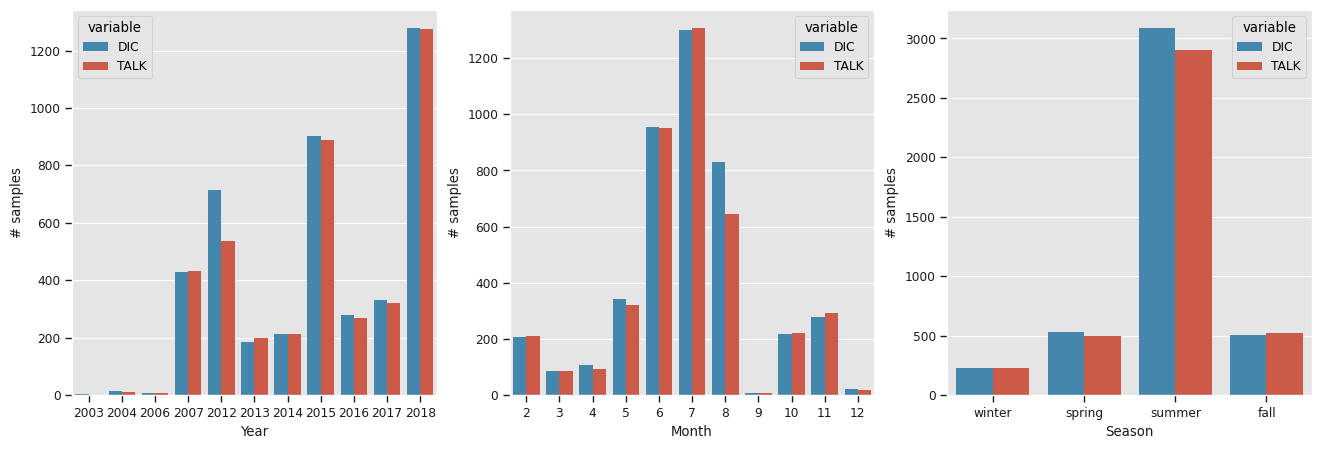

In [6]:
df_dic1 = df_bottle_dic.groupby(df_bottle_dic.Date.dt.year)[['DIC']].count()
df_ta1 = df_bottle_ta.groupby(df_bottle_ta.Date.dt.year)[['TALK']].count()
df_year = (
    df_dic1.join(df_ta1)
    .fillna(0)
    .reset_index()
    .melt(value_vars=['DIC','TALK'], id_vars='Date')
    .rename(columns={'Date':'Year', 'value':'# samples'})
)
df_dic2 = df_bottle_dic.groupby('Season')[['DIC']].count()
df_ta2 = df_bottle_ta.groupby('Season')[['TALK']].count()
df_season = (
    df_dic2.join(df_ta2)
    .fillna(0)
    .reset_index()
    .melt(value_vars=['DIC','TALK'], id_vars='Season')
    .rename(columns={'Date':'Year', 'value':'# samples'})
)
df_dic3 = df_bottle_dic.groupby(df_bottle_dic.Date.dt.month)[['DIC']].count()
df_ta3 = df_bottle_ta.groupby(df_bottle_ta.Date.dt.month)[['TALK']].count()
df_month = (
    df_dic3.join(df_ta3)
    .fillna(0)
    .reset_index()
    .melt(value_vars=['DIC','TALK'], id_vars='Date')
    .rename(columns={'Date':'Month', 'value':'# samples'})
)
fig, axs = plt.subplots(1, 3, figsize=(16, 5))
_ = sns.barplot(x='Year', y='# samples', data=df_year, hue='variable', ax=axs[0])
_ = sns.barplot(x='Month', y='# samples', data=df_month, hue='variable', ax=axs[1])
_ = sns.barplot(x='Season', y='# samples', data=df_season, hue='variable', order=['winter','spring','summer','fall'], ax=axs[2])

## Add atmospheric pCO2 data (annual mean) 

In [7]:
# load at pCO2 data
df_atm_pco2 = pd.read_csv('data/co2_annmean_mlo.csv', skiprows=59)
df_atm_pco2 = df_atm_pco2.rename(columns={'mean':'pCO2_atm'}).drop('unc', axis=1)
# df_atm_pco2.head()

df_bottle_dic['year'] = df_bottle_dic.Date.dt.year
df_bottle_dic = pd.merge(df_bottle_dic, df_atm_pco2, on='year').drop('year', axis=1)

df_bottle_ta['year'] = df_bottle_ta.Date.dt.year
df_bottle_ta = pd.merge(df_bottle_ta, df_atm_pco2, on='year').drop('year', axis=1)

## Add satellite data

In [ ]:
# extract satellite data at observation dates & locations

def extract_satellite_data(df_in):
    ssh_dir = '/bali/data/ilima/Satellite_Data/AVISO/daily/'
    sst_dir = '/bali/data/ilima/Satellite_Data/SST/NOAA_OI/'
    # sst_hr_dir = '/bali/data/ilima/Satellite_Data/SST/PO.DAAC/'
    sst_hr_dir = '/home/ivan/Data/Postproc/Satellite_Data/PO.DAAC/'
    chl_dir = '/bali/data/ilima/Satellite_Data/Ocean_Color/Chl/daily/'
    kd490_dir = '/bali/data/ilima/Satellite_Data/Ocean_Color/KD490/daily/'
    
    df_obs = df_in.copy()
    for i in df_obs.index:
        year, month, day = df_obs.loc[i,'Date'].year, df_obs.loc[i,'Date'].month, df_obs.loc[i,'Date'].day
        doy = df_obs.loc[i,'Date'].day_of_year

        # extract AVISO SSH data
        ssh_file = glob.glob(ssh_dir + '{}/{:02}/dt_global_allsat_phy_l4_{}{:02}{:02}_????????.nc'.format(year,month,year,month,day))
        if ssh_file:
            with xr.open_dataset(ssh_file[0]) as ds:
                lon_sat, lat_sat = np.meshgrid(ds.longitude, ds.latitude)
                lon_obs, lat_obs = df_obs.loc[i,['Longitude','Latitude']]
                lon_obs = lon_obs + 360.
                for var in ['adt','sla']:
                    df_obs.loc[i,var.upper()] = extract_loc(lon_obs, lat_obs, lon_sat, lat_sat, da2ma(ds[var]))
        else:
            print('SSH i={} ({}-{:02}-{:02})'.format(i, year, month, day), end=', ')

        # extract SST (0.25 x 0.25 degree) data
        sst_file = glob.glob(sst_dir + '{}/{:03d}/{}*AVHRR_OI*.nc'.format(year,doy,year))
        if sst_file:
            with xr.open_dataset(sst_file[0]) as ds:
                lon_sat, lat_sat = np.meshgrid(ds.lon, ds.lat)
                lon_obs, lat_obs = df_obs.loc[i,['Longitude','Latitude']]
                data = da2ma(ds['analysed_sst'].squeeze() - 273.15) # Kelvin -> Celsius
                df_obs.loc[i,'SST'] = extract_loc(lon_obs, lat_obs, lon_sat, lat_sat, data)
        else:
            print('SST1 i={} ({}-{:02}-{:02})'.format(i, year, month, day), end=', ')

        # extract high res SST (0.01 x 0.01 degree) data
        # sst_hr_file = sst_hr_dir + '{}/{:03d}/{}{:02}{:02}090000-JPL-L4_GHRSST-SSTfnd-MUR-GLOB-v02.0-fv04.1.nc'.format(year,doy,year,month,day)
        sst_hr_file = sst_hr_dir + 'subset_{}{:02}{:02}090000-JPL-L4_GHRSST-SSTfnd-MUR-GLOB-v02.0-fv04.1.nc'.format(year,month,day)
        if os.path.isfile(sst_hr_file):
            with xr.open_dataset(sst_hr_file) as ds:
                lon_sat, lat_sat = np.meshgrid(ds.lon, ds.lat)
                lon_obs, lat_obs = df_obs.loc[i,['Longitude','Latitude']]
                data = da2ma(ds['analysed_sst'].squeeze() - 273.15) # Kelvin -> Celsius
                df_obs.loc[i,'SST_hires'] = extract_loc(lon_obs, lat_obs, lon_sat, lat_sat, data)
        else:
            print('SST2 i={} ({}-{:02}-{:02})'.format(i, year, month, day), end=', ')

        # extract surface Chl (~4.64 Km resolution)
        chl_file = chl_dir + '{}/{:02}/{}{:02}{:02}_d-ACRI-L4-CHL-MULTI_4KM-GLO-REP.nc'.format(year,month,year,month,day)
        if os.path.isfile(chl_file):
            with xr.open_dataset(chl_file) as ds:
                lon_sat, lat_sat = np.meshgrid(ds.lon, ds.lat)
                lon_obs, lat_obs = df_obs.loc[i,['Longitude','Latitude']]
                data = da2ma(ds['CHL'].squeeze())
                df_obs.loc[i,'Chl'] = extract_loc(lon_obs, lat_obs, lon_sat, lat_sat, data)
        else:
            print('Chl i={} ({}-{:02}-{:02})'.format(i, year, month, day), end=', ')

        # extract surface KD490 (~4.64 Km resolution)
        kd490_file = kd490_dir + '{}/{:02}/{}{:02}{:02}_d-ACRI-L4-KD490-MULTI_4KM-GLO-REP.nc'.format(year,month,year,month,day)
        if os.path.isfile(kd490_file):
            with xr.open_dataset(kd490_file) as ds:
                lon_sat, lat_sat = np.meshgrid(ds.lon, ds.lat)
                lon_obs, lat_obs = df_obs.loc[i,['Longitude','Latitude']]
                data = da2ma(ds['KD490'].squeeze())
                df_obs.loc[i,'KD490'] = extract_loc(lon_obs, lat_obs, lon_sat, lat_sat, data)
        else:
            print('KD490 i={} ({}-{:02}-{:02})'.format(i, year, month, day), end=' | ')

    return df_obs

df_bottle_dic = extract_satellite_data(df_bottle_dic)
df_bottle_ta = extract_satellite_data(df_bottle_ta)

## Save cleaned data to CSV file

In [ ]:
df_bottle_dic.to_csv('data/bottle_data_DIC_prepared.csv')
df_bottle_ta.to_csv('data/bottle_data_TA_prepared.csv')